In [ ]:
import json
import os
from PIL import Image

def process_json_files(path):
    for filename in os.listdir(path):
        if filename.endswith(".json"):
            json_file_path = os.path.join(path, filename)
            with open(json_file_path, 'r') as file:
                data = json.load(file)

            # hc 라벨이 있는지 확인
            hc_labels = [shape for shape in data['shapes'] if shape['label'] == 'hc']
            
            if len(hc_labels):
                hc_labels = [hc_labels[0]]
            
            if hc_labels:
                process_hc_labels(hc_labels, data, path, filename)
                
def process_hc_labels(hc_labels, data, path, json_filename):
    image_path = os.path.join(path, data['imagePath'])
    image = Image.open(image_path)

    # x의 최소, 최대 좌표와 y의 최소 좌표를 구하기
    x_min = min(hc_label['points'][0][0] for hc_label in hc_labels)
    x_max = max(hc_label['points'][1][0] for hc_label in hc_labels)
    y_min = min(hc_label['points'][0][1] for hc_label in hc_labels) - 100

    # 이미지 자르기
    cropped_image = image.crop((0, y_min, image.size[0], image.size[1]))

    # 좌표 수정
    for hc_label in hc_labels:
        hc_label['points'][0][1] -= y_min
        hc_label['points'][1][1] -= y_min
        hc_label['points'][0][0] = 0
        hc_label['points'][1][0] = image.size[0]

    # 새로운 이미지명으로 저장
    new_image_name = f"{os.path.splitext(data['imagePath'])[0]}_1.png"
    
    new_path = "/Users/gwonsmpro/Desktop/hc_test_folder"
    # cropped_image.save(os.path.join(path, new_image_name))
    cropped_image.save(os.path.join(new_path, new_image_name))
    
    # JSON 파일 업데이트
    new_json_data = {
        "version": data["version"],
        "flags": data["flags"],
        "shapes": hc_labels,
        "imagePath": new_image_name,
        "imageData": None,
        "imageWidth": cropped_image.size[0],
        "imageHeight": cropped_image.size[1]
    }

    # 새로운 JSON 파일로 저장
    new_json_file_name = os.path.splitext(json_filename)[0] + "_1.json"
    with open(os.path.join(new_path, new_json_file_name), 'w') as file:
        json.dump(new_json_data, file)

In [ ]:
os_list = [cls for cls in os.listdir("/Users/gwonsmpro/Downloads/pillipse/test_hc/") if os.path.isdir(os.path.join("/Users/gwonsmpro/Downloads/pillipse/test_hc/",cls))]

for cls in os_list:
    process_json_files(f"/Users/gwonsmpro/Downloads/pillipse/test_hc/{cls}")

In [ ]:
import shutil

def process_json_files(path, dest_path):
    for filename in os.listdir(path):
        if filename.endswith(".json"):
            json_file_path = os.path.join(path, filename)
            with open(json_file_path, 'r') as file:
                data = json.load(file)

            # hc 라벨이 있는지 확인
            hc_labels = [shape for shape in data['shapes'] if shape['label'] == 'hc']

            if hc_labels:
                shutil.copy(json_file_path, dest_path)

                # 동일한 이름의 png 파일 복사
                png_filename = os.path.splitext(filename)[0] + ".png"
                png_file_path = os.path.join(path, png_filename)
                if os.path.exists(png_file_path):
                    shutil.copy(png_file_path, dest_path)

base_path = "C:/Users/lee97/OneDrive/바탕 화면/test_hc/sc"
dest_path = "C:/Users/lee97/OneDrive/바탕 화면/test_hc/dest_path"
process_json_files(base_path, dest_path)

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import json

unprocessed_cnt = 0

base_path = "C:/Users/lee97/OneDrive/바탕 화면/test_hc/compared"
img_list = Path(base_path).glob("*.png")
clahe = cv2.createCLAHE(clipLimit=1.3, tileGridSize=(8, 8))

for img_path in (img_list):
    img_path = str(img_path)
    
    img_array = np.fromfile(img_path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    # img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    projection_h = np.sum(gray[gray.shape[1]//2:, :], axis=1, dtype=np.int64)
    peak_h = np.diff(projection_h)


    mini = min(peak_h.argmin(), peak_h.argmax())
    maxi = max(peak_h.argmin(), peak_h.argmax())

    # print(mini, maxi)

    # crop_image_color = image[gray.shape[1]//2 + mini-100:gray.shape[1]//2 + mini, :, :]
    # crop_image_color = cv2.resize(crop_image_color, (crop_image_color.shape[1], crop_image_color.shape[0]*5))

    # 흰색에 가까운 색상 범위 정의
    # lower_white = np.array([170, 170, 170], dtype=np.uint8)
    # upper_white = np.array([255, 255, 255], dtype=np.uint8)

    # 흰색에 가까운 픽셀 마스크 생성
    # white_mask = cv2.inRange(crop_image_color, lower_white, upper_white)

    gray_crop = gray[gray.shape[1]//2 + mini-100:gray.shape[1]//2 + mini, :]
    gray_crop = cv2.resize(gray_crop, (gray_crop.shape[1], gray_crop.shape[0]*5))

    image_clahe = clahe.apply(gray_crop)

    adaptive_thresh = cv2.adaptiveThreshold(
        image_clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # 흰색에 가까운 픽셀만 이진화 (Otsu 적용)
    # _, white_binary = cv2.threshold(white_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    # 흰색에 가까운 픽셀을 제외한 나머지 픽셀 이진화 (Otsu 적용)
    # non_white_mask = cv2.bitwise_not(white_mask)
    non_white_mask = cv2.bitwise_not(adaptive_thresh)

    

    _, non_white_binary = cv2.threshold(non_white_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(non_white_binary, connectivity=8)
    shapes = []

    
    for i in range(1, num_labels):  # 배경 레이블 제외
        x, y, w, h, area = stats[i]
        if 100000 > area > 700:  # 노이즈 제거
            y_start = int(mini) - 100 + int(y / 5) + gray.shape[1]//2
            if y_start >= (mini + gray.shape[1]//2 -30):
                y_end = int(mini) - 100 + int((y + h) / 5) + gray.shape[1]//2
                points = [[int(x), y_start], [int(x + w), y_end]]
                shape = {
                    "label"     : r"hc",
                    "points"    : points,
                    "group_id"  : None,
                    "shape_type": "rectangle",
                    "flags"     : {}
                }
                shapes.append(shape)


    if not shapes:
        unprocessed_cnt += 1
        print(img_path)
        
    # JSON 형식으로 저장
    json_data = {
        "version"    : "4.5.6",
        "flags"      : {},
        "shapes"     : shapes,
        "lineColor"  : [0, 255, 0, 128],
        "fillColor"  : [255, 0, 0, 128],
        "imagePath"  : os.path.basename(img_path),
        "imageData"  : None,
        "imageHeight": image.shape[0],
        "imageWidth" : image.shape[1],
    }

    json_path = str(Path(img_path).with_suffix(".json"))
    with open(json_path, 'w') as json_file: 
        json.dump(json_data, json_file, indent=4)

    # print(f"Bounding boxes saved to {json_path}")

print(unprocessed_cnt)

C:\Users\lee97\OneDrive\바탕 화면\test_hc\compared\Insp_163411_0.png
C:\Users\lee97\OneDrive\바탕 화면\test_hc\compared\Insp_164035_0.png
C:\Users\lee97\OneDrive\바탕 화면\test_hc\compared\Insp_180640_1.png
3


In [ ]:
stats

1470 1474


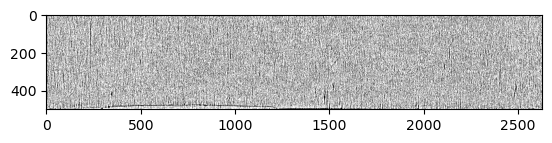

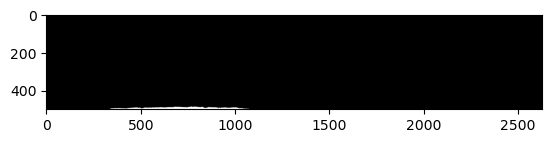

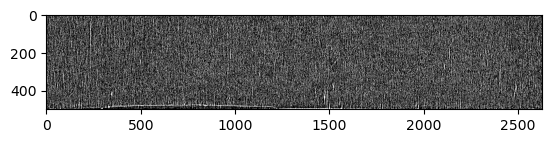

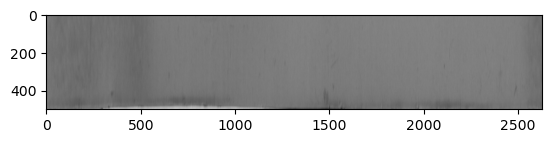

shape: {'label': 'hc', 'points': [[898, 2768], [1005, 2784]], 'group_id': None, 'shape_type': 'rectangle', 'flags': {}} || area: 1034
shape: {'label': 'hc', 'points': [[451, 2771], [562, 2783]], 'group_id': None, 'shape_type': 'rectangle', 'flags': {}} || area: 909
shape: {'label': 'hc', 'points': [[1265, 2775], [1497, 2784]], 'group_id': None, 'shape_type': 'rectangle', 'flags': {}} || area: 994
Bounding boxes saved to C:\Users\lee97\OneDrive\바탕 화면\test_hc\compared\ul_7.json


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import json

base_path = "C:/Users/lee97/OneDrive/바탕 화면/test_hc/compared"
img_path  = os.path.join(base_path, "ul_7.png")
img_path  = str(img_path)
img_array = np.fromfile(img_path, np.uint8)
image     = cv2.imdecode(img_array, cv2.IMREAD_COLOR)


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
projection_h = np.sum(gray[gray.shape[1]//2:, :], axis=1, dtype=np.int64)
peak_h = np.diff(projection_h)
mini = min(peak_h.argmin(), peak_h.argmax())
maxi = max(peak_h.argmin(), peak_h.argmax())
print(mini, maxi)


crop_image_color = image[gray.shape[1]//2 + mini-100:gray.shape[1]//2 + mini, :, :]
crop_image_color = cv2.resize(crop_image_color, (crop_image_color.shape[1], crop_image_color.shape[0]*5))

# 흰색에 가까운 색상 범위 정의
lower_white = np.array([170, 170, 170], dtype=np.uint8)
upper_white = np.array([255, 255, 255], dtype=np.uint8)

# 흰색에 가까운 픽셀 마스크 생성
white_mask = cv2.inRange(crop_image_color, lower_white, upper_white)

# 흰색에 가까운 픽셀만 이진화 (Otsu 적용)
_, white_binary = cv2.threshold(white_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

gray_crop = gray[gray.shape[1]//2 + mini-100:gray.shape[1]//2 + mini, :]
gray_crop = cv2.resize(gray_crop, (gray_crop.shape[1], gray_crop.shape[0]*5))

adaptive_thresh = cv2.adaptiveThreshold(
    img_clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 11, 2
)

# adaptive_thresh = cv2.resize(adaptive_thresh, ((gray_crop.shape[1], gray_crop.shape[0]*5)))

# gray_threshold, gray_white_binary = cv2.threshold(gray_crop, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# # 흰색에 가까운 픽셀 이진화 이미지
# # plt.imshow(white_binary, cmap='gray')
# # plt.show()

# 흰색에 가까운 픽셀을 제외한 나머지 픽셀 이진화 (Otsu 적용)
non_white_mask = cv2.bitwise_not(white_mask)
non_white_mask = cv2.bitwise_not(adaptive_thresh)

_, non_white_binary = cv2.threshold(non_white_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(adaptive_thresh, cmap='gray')
plt.show()

plt.imshow(white_mask, cmap='gray')
plt.show()
# 흰색에 가까운 픽셀을 제외한 이진화 이미지
plt.imshow(non_white_binary, cmap='gray')
plt.show()

plt.imshow(crop_image_color, cmap='gray')
plt.show()

# plt.imshow(gray_white_binary)
# plt.show()

num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(non_white_binary, connectivity=8)
# num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(gray_white_binary, connectivity=8)
# Bounding Box 및 Labelme JSON 구조 생성
shapes = []
for i in range(1, num_labels):  # 배경 레이블 제외
    x, y, w, h, area = stats[i]
    # print(area)
    if 100000 > area > 500:  # 노이즈 제거
        y_start = int(mini) - 100 + int(y / 5) + gray.shape[1]//2
        if y_start >= (mini + gray.shape[1]//2 -30):
            y_end = int(mini) - 100 + int((y + h) / 5) + gray.shape[1]//2
            points = [[int(x), y_start], [int(x + w), y_end]]
            shape = {
                "label": r"hc",
                "points": points,
                "group_id": None,
                "shape_type": "rectangle",
                "flags": {}
            }
            shapes.append(shape)
            print(f"shape: {shape} || area: {area}")


# JSON 형식으로 저장
json_data = {
    "version": "4.5.6",
    "flags": {},
    "shapes": shapes,
    "lineColor": [0, 255, 0, 128],
    "fillColor": [255, 0, 0, 128],
    "imagePath": os.path.basename(img_path),
    "imageData": None,
    "imageHeight": image.shape[0],
    "imageWidth": image.shape[1],
}

json_path = str(Path(img_path).with_suffix(".json"))
with open(json_path, 'w') as json_file:
    json.dump(json_data, json_file, indent=4)

print(f"Bounding boxes saved to {json_path}")

# for i in range(1, num_labels):  # 배경 레이블 제외
#     x, y, w, h, area = stats[i]
    
#     if 700 < area < 100000:
#         print(area, y)
#         y_start = int(mini) - 100 + int(y / 5) + gray.shape[1]//2
#         print(y_start,mini + gray.shape[1]//2)

In [33]:
np.unique(non_white_binary)
print(np.unique(adaptive_thresh))

[  0 255]


1470 1474


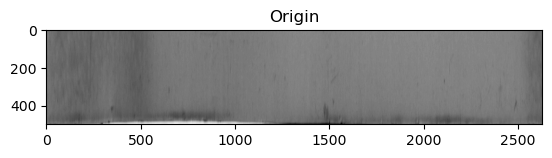

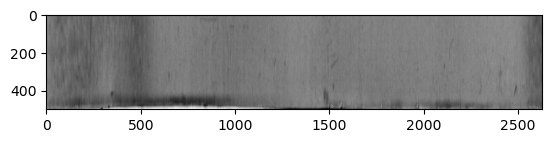

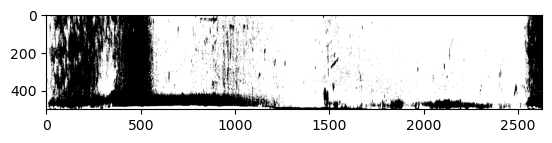

In [35]:
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

base_path = "C:/Users/lee97/OneDrive/바탕 화면/test_hc/compared"
img_path = os.path.join(base_path, "ul_7.png")
img_path = str(img_path)


img_array = np.fromfile(img_path, np.uint8)
image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
projection_h = np.sum(gray[gray.shape[1]//2:, :], axis=1, dtype=np.int64)
peak_h = np.diff(projection_h)
mini = min(peak_h.argmin(), peak_h.argmax())
maxi = max(peak_h.argmin(), peak_h.argmax())
print(mini, maxi)

gray_crop = gray[gray.shape[1]//2 + mini-100:gray.shape[1]//2 + mini, :]
gray_crop = cv2.resize(gray_crop, (gray_crop.shape[1], gray_crop.shape[0]*5))

clahe = cv2.createCLAHE(clipLimit=1.3, tileGridSize=(8, 8))

img_clahe = clahe.apply(gray_crop)

plt.imshow(gray_crop, cmap='gray')
plt.title("Origin")
plt.show()

plt.imshow((img_clahe).astype(np.uint8), cmap='gray')  # 시각화를 위해 0~255 범위로 변경
plt.show()

_, non_white_binary = cv2.threshold(img_clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(non_white_binary, cmap='gray')
plt.show()


In [23]:
gray_crop.shape

(500, 2800)

# Calculate IoU

In [ ]:
from pathlib import Path
import json
import numpy as np  # NumPy를 추가로 임포트합니다.

# Partial IoU 계산 함수
def get_partial_iou(box1, box2):
    intersect_x_min = max(box1[0][0], box2[0][0])
    intersect_y_min = max(box1[0][1], box2[0][1])
    intersect_x_max = min(box1[1][0], box2[1][0])
    intersect_y_max = min(box1[1][1], box2[1][1])

    if intersect_x_max < intersect_x_min or intersect_y_max < intersect_y_min:
        return 0.0

    intersect_area = (intersect_x_max - intersect_x_min) * (intersect_y_max - intersect_y_min)

    box1_area = (box1[1][0] - box1[0][0]) * (box1[1][1] - box1[0][1])
    
    partial_iou = intersect_area / box1_area
    
    return partial_iou

# 기존 코드
compared_path = "c:/Users/lee97/OneDrive/바탕 화면/test_hc/compared"
dest_path = "c:/Users/lee97/OneDrive/바탕 화면/test_hc/dest_path"

compared_json_list = sorted(list(Path(compared_path).glob("*.json"))[:10])
dest_json_list = sorted(list(Path(dest_path).glob("*.json"))[:10])

assert len(compared_json_list) == len(dest_json_list)

all_partial_ious = []  # 모든 이미지에 대한 Partial IoU 값을 저장할 리스트

for idx, (case1, case2) in enumerate(zip(compared_json_list, dest_json_list)):
    print(idx, case1, case2)
    
    with open(str(case1), "r") as f1:
        case1_data = json.load(f1)
    
    with open(str(case2), "r") as f2:
        case2_data = json.load(f2)

    hc_boxes_case1 = [shape["points"] for shape in case1_data["shapes"] if shape["label"] == "hc"]
    hc_boxes_case2 = [shape["points"] for shape in case2_data["shapes"] if shape["label"] == "hc"]

    # Partial IoU 계산
    partial_ious = []
    intersect_flags = [0] * len(hc_boxes_case2)  # 겹치는 박스가 있는지 표시할 플래그

    for box1 in hc_boxes_case1:
        max_partial_iou = 0
        for i, box2 in enumerate(hc_boxes_case2):
            partial_iou = get_partial_iou(box1, box2)
            max_partial_iou = max(max_partial_iou, partial_iou)
            if partial_iou > 0:
                intersect_flags[i] = 1  # 겹치는 박스가 있다면 플래그를 1로 설정
        partial_ious.append(max_partial_iou)
    
    # 겹치지 않는 박스에 대한 IoU 값 0 추가
    for flag in intersect_flags:
        if flag == 0:
            partial_ious.append(0.0)

    print("Partial IoUs:", partial_ious)
    
    # 모든 이미지에 대한 Partial IoU 값 저장
    all_partial_ious.extend(partial_ious)

# mIoU 계산
if all_partial_ious:
    mIoU = np.mean(all_partial_ious)
else:
    mIoU = 0.0

print(f"Mean IoU (mIoU): {mIoU}")
